## Agência Nacional do Cinema - ANCINE

### Desafios e Oportunidades na Indústria Cinematográfica Brasileira

#### **Análise Exploratória de Dados**

Este projeto tem como objetivo realizar uma Análise Exploratória de Dados (EDA) sobre o conjunto de dados abertos ANCINE - Agência Nacional do Cinema. 

Neste estudo, foram explorados os dados referentes aos Agentes Econômicos cadastrados na ANCINE, assim como suas atividades, Investidores,  Obras cinematográficas, Projetos contratados e outros. 


---

## 0. Imports e Carregamento do Projeto

In [101]:
import math

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from collections import Counter as co
from matplotlib import pyplot as plt, gridspec
from matplotlib import font_manager as fm
from wordcloud import WordCloud as wc
from v2_abrir_projeto import Projeto
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

pj = Projeto()
pj.abrir_projeto()


***Bem vindo(a) ao Projeto!***

Para ler documentação: "pj.doc.documentacao"



### 0.1  Exibição da Documentação basilar para navegação.

In [102]:
pj.doc.documentacao()

**** DOCUMENTAÇÃO DO PROJETO ****
***Agência Nacional do Cinema***

Cada Arquivo CSV contém uma variável raíz e um 
número de referência para variáveis específicas.
*
*
Para chamar variável no Jupyter Notebook digite: "df." + variável
*
Para chamar variável específica digite: "df." + "variável_especifica" + número
*
*
Nome arquivo CSV | Nome variável raíz | Número variável específica
-
Agentes Econômicos Regulares = agnts_economicos = 1  
Atividades Economicas dos Agentes Regulares = atividade_economicas_agnts = 2 
Projetos Renúncia Fiscal = proj_renuncia_fiscal = 3  
Obras não Publicitárias Brasileiras - Fomento Indireto = obras_n_publi_fomento_direto =  4 
Obras não Publcitárias Brasileiras - Investimento FSA = obras_n_publi_investimento_fsa =  5 
Processos de Prestação de contas = processos_prestacao_contas = 6  
Investidores de projetos de Renúncia Fiscal = investidores_proj_renuncia_fiscal = 7   
Produtoras Independentes = produtoras_independentes = 8 
Produtores de obra não Publi

### 0.2 Função para carregar variáveis no ambiente local do projeto

In [103]:
#Carregar variáveis no ambiente local (Método para economizar tempo de digitação)
def carregar():
        
        from pandas import DataFrame as pd

        global agnts_economicos
        agnts_economicos = pd(pj.df.agnts_economicos)
        global atividade_economicas_agnts
        atividade_economicas_agnts = pd(pj.df.atividade_economicas_agnts)
        global proj_renuncia_fiscal
        proj_renuncia_fiscal = pd(pj.df.proj_renuncia_fiscal)
        global obras_n_publi_fomento_direto
        obras_n_publi_fomento_direto = pd(pj.df.obras_n_publi_fomento_direto)
        global obras_n_publi_investimento_fsa
        obras_n_publi_investimento_fsa = pd(pj.df.obras_n_publi_investimento_fsa)
        global processos_prestacao_contas
        processos_prestacao_contas = pd(pj.df.processos_prestacao_contas)
        global investidores_proj_renuncia_fiscal
        investidores_proj_renuncia_fiscal = pd(pj.df.investidores_proj_renuncia_fiscal)
        global produtoras_independentes
        produtoras_independentes = pd(pj.df.produtoras_independentes)
        global produtores_obras_n_publi
        produtores_obras_n_publi = pd(pj.df.produtores_obras_n_publi)
        global proj_fsa_desembolso
        proj_fsa_desembolso = pd(pj.df.proj_fsa_desembolso)
        global relacao_grupos_economicos
        relacao_grupos_economicos = pd(pj.df.relacao_grupos_economicos)
        global salas_complexos
        salas_complexos = pd(pj.df.salas_complexos)    
carregar()

---

## 1. Carregamento de dados


*Por conta do modelo de POO que foi aplicado nesse projeto, os dados foram previamente pré-processados, ou seja, não vamos encontrar tabelas com valores nulos ou colunas com tipos de dados equivocados. Para conhecer a documentação desse processo, clique [aqui](https://github.com/fonsecadados/AgenciaNacionalDoCinema_ANCINE/blob/main/processamento_dados.py).*

### 1.2 Unificar Tabelas

Para maior eficiência no código, vamos unificar as tabelas "Agentes Econômicos" e "Atividade dos Agentes Econômicos"

#### 1.2.1 Agentes Econômicos x Atividade dos Agentes Econômicos x Produtores Independentes

In [132]:
def unificar_tabelas_agentes(): #Criando Dataframe merged Agentes Economicos Regulares x Atividades Economicas dos Agentes

    agnts_atividades_economicas = pd.merge(agnts_economicos, atividade_economicas_agnts, on='REGISTRO_ANCINE', how='inner') #Merge tabelas agnt econômicos e atividades
    agnts_atividades_economicas = agnts_atividades_economicas[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL_x', 'CNPJ_x', #selecionando colunas
        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA', 'ATIVIDADE_ECONOMICA','CLASSIFICACAO_ATIVIDADE', 'BRASILEIRO_INDEPENDENTE']]

    agnts_atividades_economicas.rename(columns={'RAZAO_SOCIAL_x' : 'RAZAO_SOCIAL', 'CNPJ_x' : 'CNPJ'}, inplace=True) #corrigindo nomes das colunas

    agnts_atividades_economicas = agnts_atividades_economicas[agnts_atividades_economicas['CLASSIFICACAO_ATIVIDADE'] == 1] # filtrando a colunaClassificação de atividades para deixar apenas as principais, evitando agentes duplicados

    #Produtoras Independentes
    global produtoras_independentes
    global agnts_tabela_unificada
    global tabela_unificada_atividades_economicas

    produtoras_independentes = produtoras_independentes[['REGISTRO_ANCINE', 'CLASSIFICACAO_NIVEL_PRODUTORA']] # selecionando colunas - Produtoras Independentes
    agnts_tabela_unificada = pd.DataFrame(pd.merge(agnts_atividades_economicas, produtoras_independentes, how='outer', on='REGISTRO_ANCINE')) #Merge tabelas
    agnts_tabela_unificada.dropna(subset='CLASSIFICACAO_NIVEL_PRODUTORA', inplace=True)

    agnts_tabela_unificada = agnts_tabela_unificada.drop_duplicates(subset=['CNPJ'])
unificar_tabelas_agentes()

#### 1.2.3 FSA Desembolso / Renúncia Fiscal x Agentes Econômicos (tabela unificada)

In [133]:
produtoras_proj_renun_fiscal = proj_renuncia_fiscal.copy()
produtoras_proj_renun_fiscal = agnts_tabela_unificada.merge(produtoras_proj_renun_fiscal, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_renun_fiscal = produtoras_proj_renun_fiscal[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO', 'LEI_8313', 'ART1',
       'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO',
       'DT_APROVACAO_CAPTACAO', 'DT_1_LIBERACAO']]


produtoras_proj_fsa_desembolso = proj_fsa_desembolso.copy()
produtoras_proj_fsa_desembolso = agnts_tabela_unificada.merge(produtoras_proj_fsa_desembolso, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_fsa_desembolso = produtoras_proj_fsa_desembolso[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO',
       'CHAMADA_PUBLICA', 'ANO_CHAMADA_PUBLICA', 'DT_PUBLICACAO_CONTRATO_DOU',
       'VL_CONTRATO_DOU', 'DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]


# FSA - DESEMBOLSO
fsa_desembolso = produtoras_proj_fsa_desembolso.copy()
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = fsa_desembolso['ANO_CHAMADA_PUBLICA'].str.split('/').str[-1] 
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = pd.to_numeric(fsa_desembolso['ANO_CHAMADA_PUBLICA'])

data_ficticia = pd.to_datetime('1900-12-31')
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].fillna(data_ficticia, inplace=True)
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'])

fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'] = pd.to_datetime(fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'])

fsa_desembolso['VL_CONTRATO_DOU'] = fsa_desembolso['VL_CONTRATO_DOU'].str.replace(',', '.').astype(float)

fsa_desembolso['VL_TOTAL_LIBERADO'] = fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
fsa_desembolso['VL_TOTAL_LIBERADO'].fillna(0, inplace=True)

fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'] = fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

fsa_desembolso['TITULO_PROJETO'].fillna('Sem Título', inplace=True)

# RENÚNICA FISCAL
renuncia_fiscal = produtoras_proj_renun_fiscal.copy()

renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'] = renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

def float_int(coluna):
    zero = '0,0'

    renuncia_fiscal[coluna] = renuncia_fiscal[coluna].str.replace(',', '.').astype(float)

float_int('LEI_8313')
float_int('ART1')
float_int('ART1A')
float_int('ART3')
float_int('ART3A')
float_int('ART39')
float_int('FUNCINES')
float_int('TOTAL_CAPTADO')

### 1.3 Visualizar Tabela

#### 1.3.1 Descrição

In [138]:
#Função que retorne o perfil de um banco de dados
def perfil_banco_dados(df):
    duplicado = df['CNPJ'].duplicated()
    soma_duplicado = duplicado.sum()
    
    print('Raio-x')
    print()
    print(df.info())
    print('----')
    
    if soma_duplicado > 0:
        print(f'A coluna CNPJ possui {soma_duplicado} valores duplicados.')
    else:
        print('A coluna CNPJ não possui valores duplicados.')
    
    print('----')
    return df.sample(5)

#### 1.3.2 Agentes (tabela unificada)

In [139]:
perfil_banco_dados(agnts_tabela_unificada)

Raio-x

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 0 to 18571
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                11354 non-null  int64         
 1   DATA_REGISTRO                  11354 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   11354 non-null  object        
 3   CNPJ                           11354 non-null  object        
 4   DATA_CONSTITUICAO              11354 non-null  datetime64[ns]
 5   UF                             11354 non-null  object        
 6   MUNICIPIO                      11354 non-null  object        
 7   NATUREZA_JURIDICA              11354 non-null  object        
 8   ATIVIDADE_ECONOMICA            11354 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        11354 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        11354 non-null  bool          
 11  CLASSIFICACA

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_ATIVIDADE,BRASILEIRO_INDEPENDENTE,CLASSIFICACAO_NIVEL_PRODUTORA
6615,38612,2018-01-17,"PLAYSTEM CONTEUDOS EM CIENCIA, TECNOLOGIA, ENG...",08.505.057/0001-54,2006-12-01,SP,SÃO PAULO,Sociedade Empresária Limitada,Desenvolvimento e licenciamento de programas d...,1,True,1.0
17268,55556,2023-10-11,MANIVA PRODUÇÕES LTDA,22.561.961/0001-08,2015-06-01,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de pós-produção cinematográfica, de...",1,True,1.0
15291,52881,2023-02-27,FATUMBI FILMS LTDA,48.782.341/0001-92,2022-12-01,DF,BRASÍLIA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0
8415,41992,2019-01-14,FISHED MARKETING E PUBLICIDADE LTDA.,30.316.836/0001-60,2018-04-27,PR,MARINGÁ,Sociedade Empresária Limitada,Marketing direto,1,True,1.0
11633,47577,2021-01-19,E.D. FONSECA HEWITT,39.741.470/0001-41,2020-11-11,ES,SÃO JOSÉ DO CALÇADO,Empresário (Individual),"Artes cênicas, espetáculos e atividades comple...",1,True,1.0


#### 1.3.3 FSA - Desembolso

In [141]:
perfil_banco_dados(fsa_desembolso)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                3353 non-null   int64         
 1   DATA_REGISTRO                  3353 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   3353 non-null   object        
 3   CNPJ                           3353 non-null   object        
 4   DATA_CONSTITUICAO              3353 non-null   datetime64[ns]
 5   UF                             3353 non-null   object        
 6   MUNICIPIO                      3353 non-null   object        
 7   NATUREZA_JURIDICA              3353 non-null   object        
 8   ATIVIDADE_ECONOMICA            3353 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  3353 non-null   int32         
 10  TITULO_PROJETO                 3353 non-null   object        
 11  CHAMADA_P

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,TITULO_PROJETO,CHAMADA_PUBLICA,ANO_CHAMADA_PUBLICA,DT_PUBLICACAO_CONTRATO_DOU,VL_CONTRATO_DOU,DT_PRIMEIRO_DESEMBOLSO,VL_TOTAL_LIBERADO
994,2148,2004-11-09,GP7 CINEMA LTDA,04.937.797/0001-09,2001-06-11,PR,CURITIBA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,IVÁN - DE VOLTA PARA O PASSADO,PRODECINE 03,2013,2015-05-20,200000.0,2015-06-12,200000.0
2416,19299,2011-07-20,CARAVELA FILMES LTDA.,13.914.178/0001-90,2011-06-30,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",1,TODA FORMA DE AMOR,PRODAV 01,2013,2017-02-21,3994930.0,2017-02-23,3994930.0
175,262,2003-01-27,MALAGUETA CINEMA E VIDEO LTDA,03.048.443/0001-40,1998-12-23,BA,SALVADOR,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,MEMÓRIAS EM MOVIMENTO,PRODAV 02 - PROJETO DERIVADO,2016,2018-05-09,300000.0,2018-05-14,300000.0
1685,13031,2007-10-10,COLATERAL FILMES LTDA.,09.059.127/0001-50,2007-08-03,RS,PORTO ALEGRE,Sociedade Empresária Limitada,Estúdios cinematográficos,2,G.I.B.I.S.,PRODAV 01,2013,2018-10-17,339900.0,2018-10-22,339900.0
1108,2719,2004-11-08,MODO OPERANTE PRODUÇÕES CULTURAIS LTDA. ME,06.992.833/0001-62,2004-08-26,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",5,A MAIS FORTE,SAV/MINC 10,2018,2019-10-30,200000.0,2019-11-07,200000.0


#### 1.3.4 Renúncia Fiscal

In [ ]:
perfil_banco_dados(renuncia_fiscal)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                2609 non-null   int64         
 1   DATA_REGISTRO                  2609 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   2609 non-null   object        
 3   CNPJ                           2609 non-null   object        
 4   DATA_CONSTITUICAO              2609 non-null   datetime64[ns]
 5   UF                             2609 non-null   object        
 6   MUNICIPIO                      2609 non-null   object        
 7   NATUREZA_JURIDICA              2609 non-null   object        
 8   ATIVIDADE_ECONOMICA            2609 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  2609 non-null   int32         
 10  TITULO_PROJETO                 2609 non-null   object        
 11  LEI_8313 

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,TITULO_PROJETO,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO,DT_APROVACAO_CAPTACAO,DT_1_LIBERACAO
1842,7087,2006-11-28,O2 CINEMA LTDA,02.525.725/0001-29,1997-10-30,SP,COTIA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,A Busca (Ex - A Cadeira do Pai),0.0,0.0,1500000.0,0.00,500000.00,0.00,2000000.0,4000000.00,2009-11-16,2011-07-29
2439,24627,2013-07-11,FORMATA PRODUCOES E CONTEUDO LTDA.,18.082.113/0001-49,2013-05-09,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,OS PARÇAS,0.0,0.0,0.0,2043118.88,956881.12,0.00,0.0,3000000.00,2016-12-13,2017-06-30
1824,6499,2006-10-02,PULSAR PRODUCOES ARTISTICAS E CULTURAIS - EIRELI,56.839.830/0001-61,1986-11-28,SP,SÃO PAULO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",2,O Signo da Cidade ( Ex.: Sonhos da Cidade),0.0,2860000.0,869000.0,0.00,0.00,0.00,0.0,3729000.00,2001-12-17,2004-08-04
1496,2238,2004-07-30,VISON PRODUÇOES ARTISTICAS LTDA.,28.629.780/0001-52,1985-08-19,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",4,NOSSA BOSSA,0.0,0.0,0.0,0.00,0.00,326653.35,0.0,326653.35,2020-04-30,2022-02-08
1667,4332,2005-06-29,MARIANA CALTABIANO CRIAÇÕES LTDA,01.833.200/0001-98,1997-03-03,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,GUI E ESTOPA NO FUNDO DO MAR (EX - NO FUNDO...,0.0,494324.0,0.0,0.00,0.00,0.00,0.0,494324.00,2007-04-25,2008-01-22


### 1.4 Dimensões e NA

In [ ]:
#Dados Categóricos
agnts_tabela_unificada_categoricos = agnts_tabela_unificada.select_dtypes(include=['object', 'bool'])

unique_values = agnts_tabela_unificada_categoricos.apply(lambda x: x.nunique())
null_values = agnts_tabela_unificada_categoricos.isnull().sum()

agnts_tabela_unificada_categoricos = pd.DataFrame({
    'Coluna' : agnts_tabela_unificada_categoricos.columns,
    'Quantidade de Valores' : unique_values.values,
    'Quantidade de Nulos' : null_values.values
})

agnts_tabela_unificada_categoricos


,Coluna,Quantidade de Valores,Quantidade de Nulos
0,RAZAO_SOCIAL,11343,0
1,CNPJ,11354,0
2,UF,27,0
3,MUNICIPIO,681,0
4,NATUREZA_JURIDICA,10,0
5,ATIVIDADE_ECONOMICA,186,0
6,BRASILEIRO_INDEPENDENTE,1,0
7,PRODUTORA_INDEPENDENTE,1,0


---

## "Produtora Independente"

In [ ]:
agnts_tabela_unificada_sem_classificacao = agnts_tabela_unificada[~agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].notna()]
agnts_tabela_unificada = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].notna()]
agnts_tabela_unificada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 0 to 18571
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                11354 non-null  int64         
 1   DATA_REGISTRO                  11354 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   11354 non-null  object        
 3   CNPJ                           11354 non-null  object        
 4   DATA_CONSTITUICAO              11354 non-null  datetime64[ns]
 5   UF                             11354 non-null  object        
 6   MUNICIPIO                      11354 non-null  object        
 7   NATUREZA_JURIDICA              11354 non-null  object        
 8   ATIVIDADE_ECONOMICA            11354 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        11354 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        11354 non-null  bool          
 11  CLASSIFICACAO_NIVEL_

#### Vamos analisar as Atividades Econômicas dos Agentes

In [ ]:
#Além de dados estatísticos sobre as atividades econômicas, vamos extrair nuvens de palavras encontradas nas 
#atividades mais recorrentes e menos recorrentes das produtoras com classificação de nível.

#Criar nuvem geral de palavras encontradas

#Criar lista de atividades econômicas
lista_atividades = agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].tolist()

palavra = []
for atividade in lista_atividades:
    palavra.extend(atividade.split())

#Excluir outliers 
lista_atividades_counter = co(lista_atividades)
palavra_counter = co(palavra) #Método para contar as palavras
print(f'Número de Atividades Econômicas distintas: {len(lista_atividades_counter)}')

atividade_economica_contagem = pd.DataFrame(agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].value_counts().head(10))
atividade_economica_contagem

Número de Atividades Econômicas distintas: 186


,count
ATIVIDADE_ECONOMICA,
"Atividades de produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",5488
Produção de filmes para publicidade,1337
Estúdios cinematográficos,676
"Artes cênicas, espetáculos e atividades complementares não especificados anteriormente",462
Agências de publicidade,364
"Atividades de pós-produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",363
"Serviços de organização de feiras, congressos, exposições e festas",227
"Atividades de produção de fotografias, exceto aérea e submarina",199
Produção teatral,194


A lista de palavras mostra uma enorme quantidade outliers que vão poluir futuramente a visualização das nuvens, como preposições, conjunções e palavras recorrentes nos títulos das atividades e que não fazem parte do contexto.

Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas
Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas


(-0.5, 799.5, 399.5, -0.5)

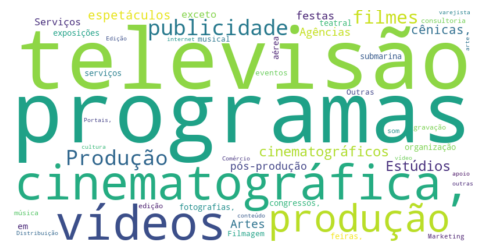

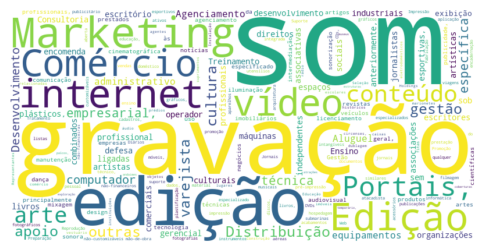

In [ ]:
#Lista de palavras da tabela de produtoras independentes para excluir
palavras_excluir = ['de', 'e', 'não', 'anteriormente', 'Atividades', 'especificadas', 'para', 'atividades',\
                     'especificados', 'complementares', 'à', 'na', 'direto', 'outros', 'informação', 'provedores']
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]
# palavras_frequencia = co(palavras_frequencia)
# Suponha que você tenha a lista de palavras filtradas armazenada em 'palavras_frequencia'
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]

# Crie um objeto Counter com as palavras filtradas
contador_palavras = co(palavras_frequencia)

# Obtenha as 25 palavras mais comuns
maior_frequencia = contador_palavras.most_common(50)
menor_frequencia = contador_palavras.most_common()[-399:]

# Converta as palavras e suas frequências em um dicionário
dic_palavras_maior_frequencia = dict(maior_frequencia)
dic_palavras_menor_frequencia = dict(menor_frequencia)

# Crie uma nuvem de palavras para as 25 palavras mais comuns
nuvem_palavras_maior_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_maior_frequencia)

# Plote a nuvem de palavras para as 25 palavras mais comuns
print('Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_maior_frequencia, interpolation='bilinear')
plt.axis('off')
# plt.show()

# Crie uma nuvem de palavras para as 415 palavras menos comuns
nuvem_palavras_menor_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_menor_frequencia)

# Plote a nuvem de palavras para as 415 palavras menos comuns
print('Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_menor_frequencia, interpolation='bilinear')
plt.axis('off')
# plt.show()

---

**Qual a distribuição geográfica dos agentes econômicos no Brasil**

Observa-se uma concentração considerável de agentes econômicos nos estados de São Paulo (SP) e Rio de Janeiro (RJ) no setor audiovisual. Tal concentração é influenciada pela centralização das atividades de mercado e da disponibilidade de mão de obra qualificada nesses dois estados.

Além da concentração de agentes dos estados de SP e RJ, vemos também uma concentração evidente nas regiões Sul e Sudeste. Vejamos esse mapa de distribuição:

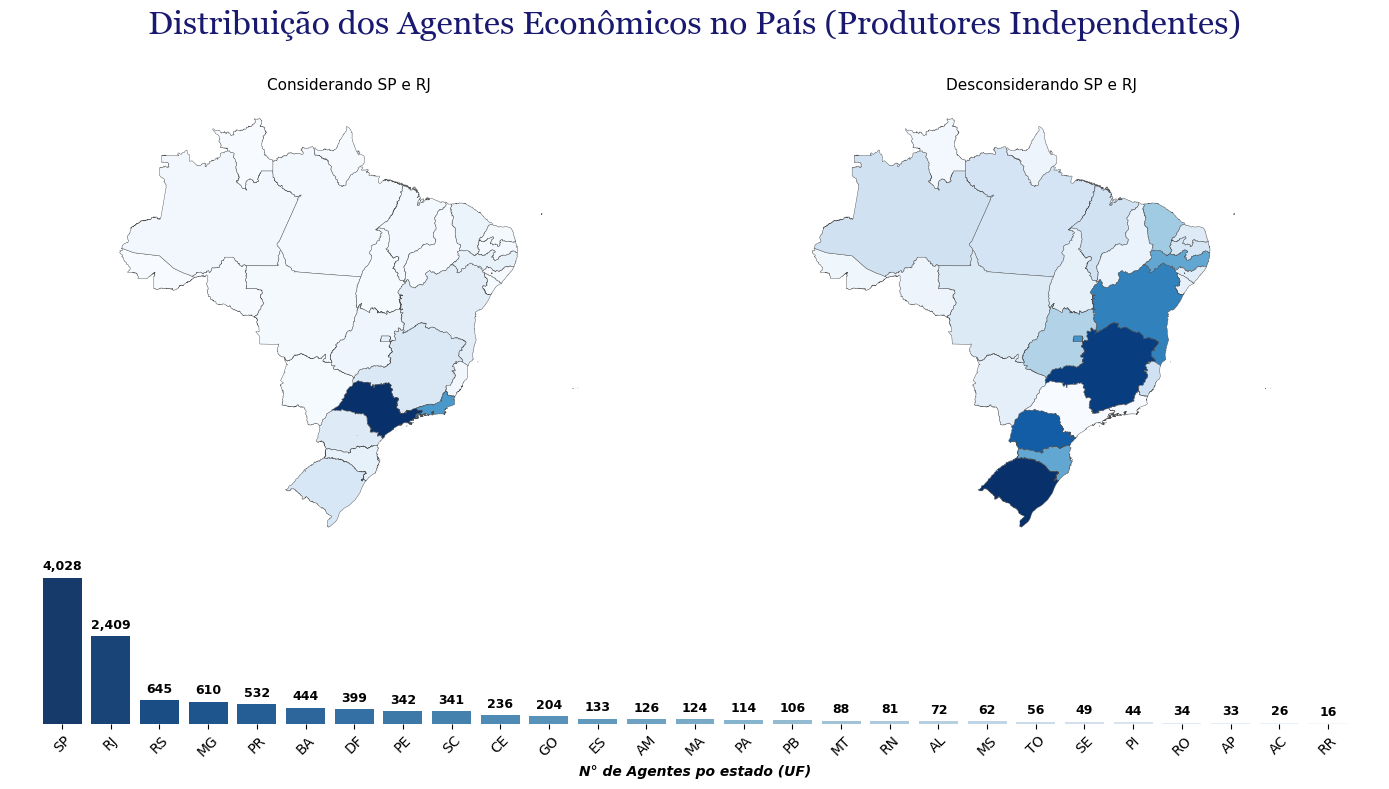

In [ ]:
# Carregar mapa BR
brasil = gpd.read_file('C:\\Users\\syafo\\OneDrive\\Documentos\\GitHub\\AgenciaNacionalDoCinema_ANCINE\\geopandas\\BR_UF_2022.shp')

# Plot com todos os estados
totais_por_estado = agnts_tabela_unificada['UF'].value_counts().reset_index()
totais_por_estado.columns = ['UF', 'Total']

brasil = brasil.merge(totais_por_estado, left_on='SIGLA_UF', right_on='UF')

# Filtrar os dados excluindo SP e RJ
estados_sem_sp_rj = agnts_tabela_unificada[(agnts_tabela_unificada['UF'] != 'RJ') & (agnts_tabela_unificada['UF'] != 'SP')]
estados_count = estados_sem_sp_rj['UF'].value_counts().reset_index()
estados_count.columns = ['UF', 'Total']

# Adicionar linhas para SP e RJ com total zero
sp_row = pd.DataFrame({'UF': ['SP'], 'Total': [0]})
rj_row = pd.DataFrame({'UF': ['RJ'], 'Total': [0]})
estados_count = pd.concat([estados_count, sp_row, rj_row], ignore_index=True)

estados_count = estados_count.sort_values(by='UF')
estados_count = estados_count.rename(columns={'UF': 'UF_count', 'Total': 'Total_count'})
brasil_estados = brasil.merge(estados_count, left_on='SIGLA_UF', right_on='UF_count')

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
brasil_estados.plot(column='Total', cmap='Blues', linewidth=0.3, ax=ax1, edgecolor='0.3', legend=False)
ax1.set_title('Considerando SP e RJ', fontsize=11, fontweight='light')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Plotar mapa dos estados com SP e RJ
ax2 = plt.subplot(gs[0,1])
brasil_estados.plot(column='Total_count', cmap='Blues', linewidth=0.3, ax=ax2, edgecolor='0.3', legend=False)
ax2.set_title('Desconsiderando SP e RJ', fontsize=11, fontweight='light')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Plotar gráfico de barras
ax3 = plt.subplot(gs[1, :])
sns.countplot(data=agnts_tabela_unificada, x='UF', order=agnts_tabela_unificada['UF'].value_counts().index, palette='Blues_r', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 8), 
                   textcoords='offset points',
                   fontsize=9, fontweight='bold')
# ax3.set_title('Quantidade de Agentes Econômicos por Estado', fontsize=13, fontweight='medium')
ax3.set_xlabel('N° de Agentes po estado (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax3.set_ylabel(None)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=10, fontweight='normal') 
ax3.set_yticks([])
ax3.margins(0.025)
plt.tight_layout()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}

plt.suptitle('Distribuição dos Agentes Econômicos no País (Produtores Independentes)', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


Para melhor compreender a distribuição dos agentes econômicos, é necessário considerar a exclusão de SP e RJ da análise. Ao realizar essa exclusão, evidenciam-se padrões diferentes de distribuição, refletindo uma dispersão mais equitativa da atividade econômica pelo território nacional. Essa alteração na distribuição reflete as dinâmicas regionais específicas do setor audiovisual fora dos polos tradicionais, revelando potenciais áreas de crescimento e desenvolvimento em outras regiões do país, como os estados da Bahia e Pernambuco, além do Distrito Federal.

Gráfico de comparação entre o número de produtoras na capital vs a somatória de produtoras fora da capital (Excluindo SP, RJ e o Distrito Federal)

Esse próximo painel constatamos 3 informações distintas e incomuns: Curiosamente, enquanto Santa Catarina é o único estado da federação onde o número de produtores em municípios não capitalinos supera o número na capital Florianópolis, Espírito Santo é o estado com a divisão mais equalizada: 49.6% em Vitória e 50.4% fora da capital. Além disso, no estado de Roraima 100% dos produtores estão na capital Boa Vista.

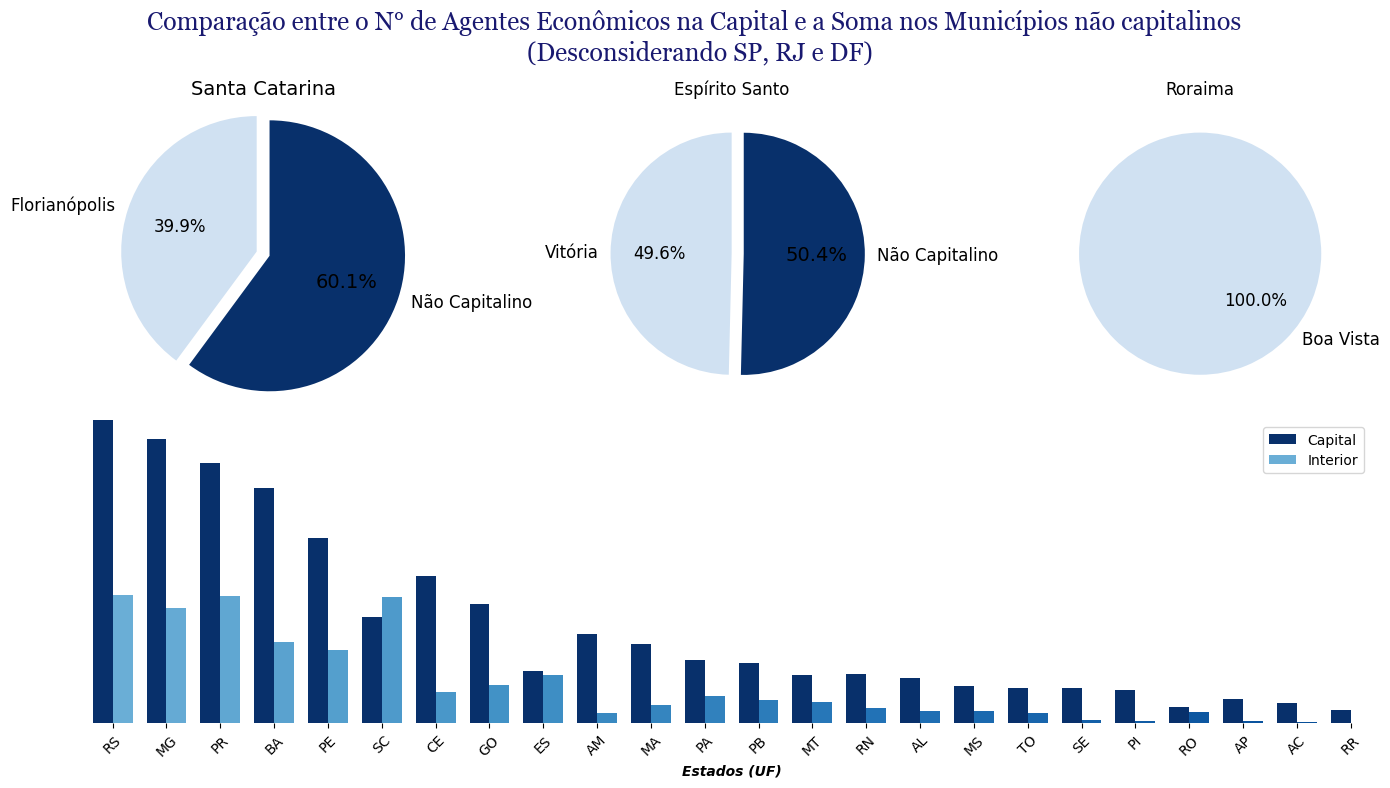

In [ ]:
#Gráficos de Pizza
santa_catarina = agnts_tabela_unificada.query("UF == 'SC'")['MUNICIPIO'].value_counts()
roraima = agnts_tabela_unificada.query("UF == 'RR'")['MUNICIPIO'].value_counts()
espirito_santo = agnts_tabela_unificada.query("UF == 'ES'")['MUNICIPIO'].value_counts()

santa_catarina_interior = santa_catarina.sum() - santa_catarina.iloc[0]
roraima_interior = roraima.sum() - roraima.iloc[0]
espirito_santo_interior = espirito_santo.sum() - espirito_santo.iloc[0]

santa_catarina_pie = {'Florianópolis': 136,
                        'Não Capitalino' : 205}

roraima_pie = {'Boa Vista': 16}

espirito_santo_pie = {'Vitória' : 66,
                      'Não Capitalino' : 67}

cores_sc = plt.cm.Blues(np.linspace(0.2, 1, len(santa_catarina_pie)))
cores_es = plt.cm.Blues(np.linspace(0.2, 1, len(roraima_pie)))
cores_rr = plt.cm.Blues(np.linspace(0.2, 1, len(espirito_santo_pie)))

####

#Gráfico de Barras
#Função para comparar o número de Agentes Econômicos nas capitais e no interior dos UFs
def capital_vs_interior(uf, produtora_classificacao):
    separar_uf = produtora_classificacao[produtora_classificacao['UF'] == uf]
    capital = separar_uf['MUNICIPIO'].value_counts().head(1)
    interior = separar_uf['MUNICIPIO'].value_counts().head(15).sum() - capital 
    nome_capital = capital.index[0]
    capital.rename(index={nome_capital : 'Capital'}, inplace=True)
    interior.rename(index={nome_capital : 'Interior'}, inplace=True)
    return capital, interior

estados = [ 'RS', 'MG', 'PR', 'BA', 'PE', 'SC', 
           'CE', 'GO', 'ES', 'AM', 'MA', 'PA', 'PB', 'MT', 
           'RN', 'AL', 'MS', 'TO', 'SE', 'PI', 'RO', 'AP', 'AC', 'RR'] #Lista de UFs

capitais = []
interiores = [] #lista para armazenar os valores

for uf in estados: #Loop for sobre cada estado
    capital, interior = capital_vs_interior(uf, agnts_tabela_unificada)
    capitais.append(capital)
    interiores.append(interior)


#####
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 3], width_ratios=[3, 3, 3])


##########################################

# Pie - Santa Catarina
ax1 = plt.subplot(gs[0, 0])
wedges, texts, autotexts = ax1.pie(santa_catarina_pie.values(), labels=santa_catarina_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax1.set_title('Santa Catarina', fontsize=14, fontweight='medium')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#Pie - Espírito Santo
ax2 = plt.subplot(gs[0, 1])
wedges, texts, autotexts = ax2.pie(espirito_santo_pie.values(), labels=espirito_santo_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax2.set_title('Espírito Santo', fontsize=12, fontweight='medium')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#Pie - Roraima
ax3 = plt.subplot(gs[0,2])
ax3.pie(roraima_pie.values(), labels=roraima_pie.keys(),colors=cores_rr,  
           autopct='%1.1f%%', startangle=140, shadow=False, textprops={'fontsize': 12, 'fontweight': 'medium'})
ax3.set_title('Roraima', fontsize=12, fontweight='medium')
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


#############
#Criação do Plot com 3 gráficos 
#Gráfico de barras       
bar_width = 0.37 #largura das barras
r1 = np.arange(len(estados)) #posição das barras
r2 = [x + bar_width for x in r1] #posição das barras
cores_int = plt.cm.Blues(np.linspace(0.5, 0.9, len(estados))) #definindo cores
cores_cap = plt.cm.Blues(np.linspace(1, 2, len(estados))) #definindo cores

ax4 = plt.subplot(gs[1, :])
# Plot das capitais
ax4 = plt.bar(r1, [c.values[0] for c in capitais], color=cores_cap, width=bar_width, label='Capital')

# Plot dos interiores
ax4 = plt.bar(r2, [i.values[0] for i in interiores], color=cores_int, width=bar_width, label='Interior')

ax4 = plt.xlabel('Estados (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax4 = plt.ylabel(None)
ax4 = plt.xticks([r + bar_width/2 for r in range(len(estados))], estados)  # Definindo os rótulos do eixo x como os estados
ax4 = plt.legend()
ax4 = plt.xticks(rotation=45, fontweight='medium')
ax4 = plt.yticks([])
ax4 = plt.margins(False)
ax4 = plt.box([])


fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Comparação entre o N° de Agentes Econômicos na Capital e a Soma nos Municípios não capitalinos \n (Desconsiderando SP, RJ e DF)', fontdict=fontprops, fontsize=18)
plt.subplots_adjust(top=0.87)
plt.tight_layout()
plt.show()


Estudando mais o tema, vamos analisar o ranking de natureza juridica dos agentes econômicos

In [ ]:
#Naturezas Jurídicas
consultas = {
    'ltda': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Empresária Limitada'"),
    'mei': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresário (Individual)'"),
    'eireli_empresaria': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)'"),
    'ss_limitada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Simples Limitada'"),
    'associacao_privada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Associação Privada'"),
    'eireli_simples': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)'"),
    'sa_fechada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Anônima Fechada'")
}

globals().update(consultas)

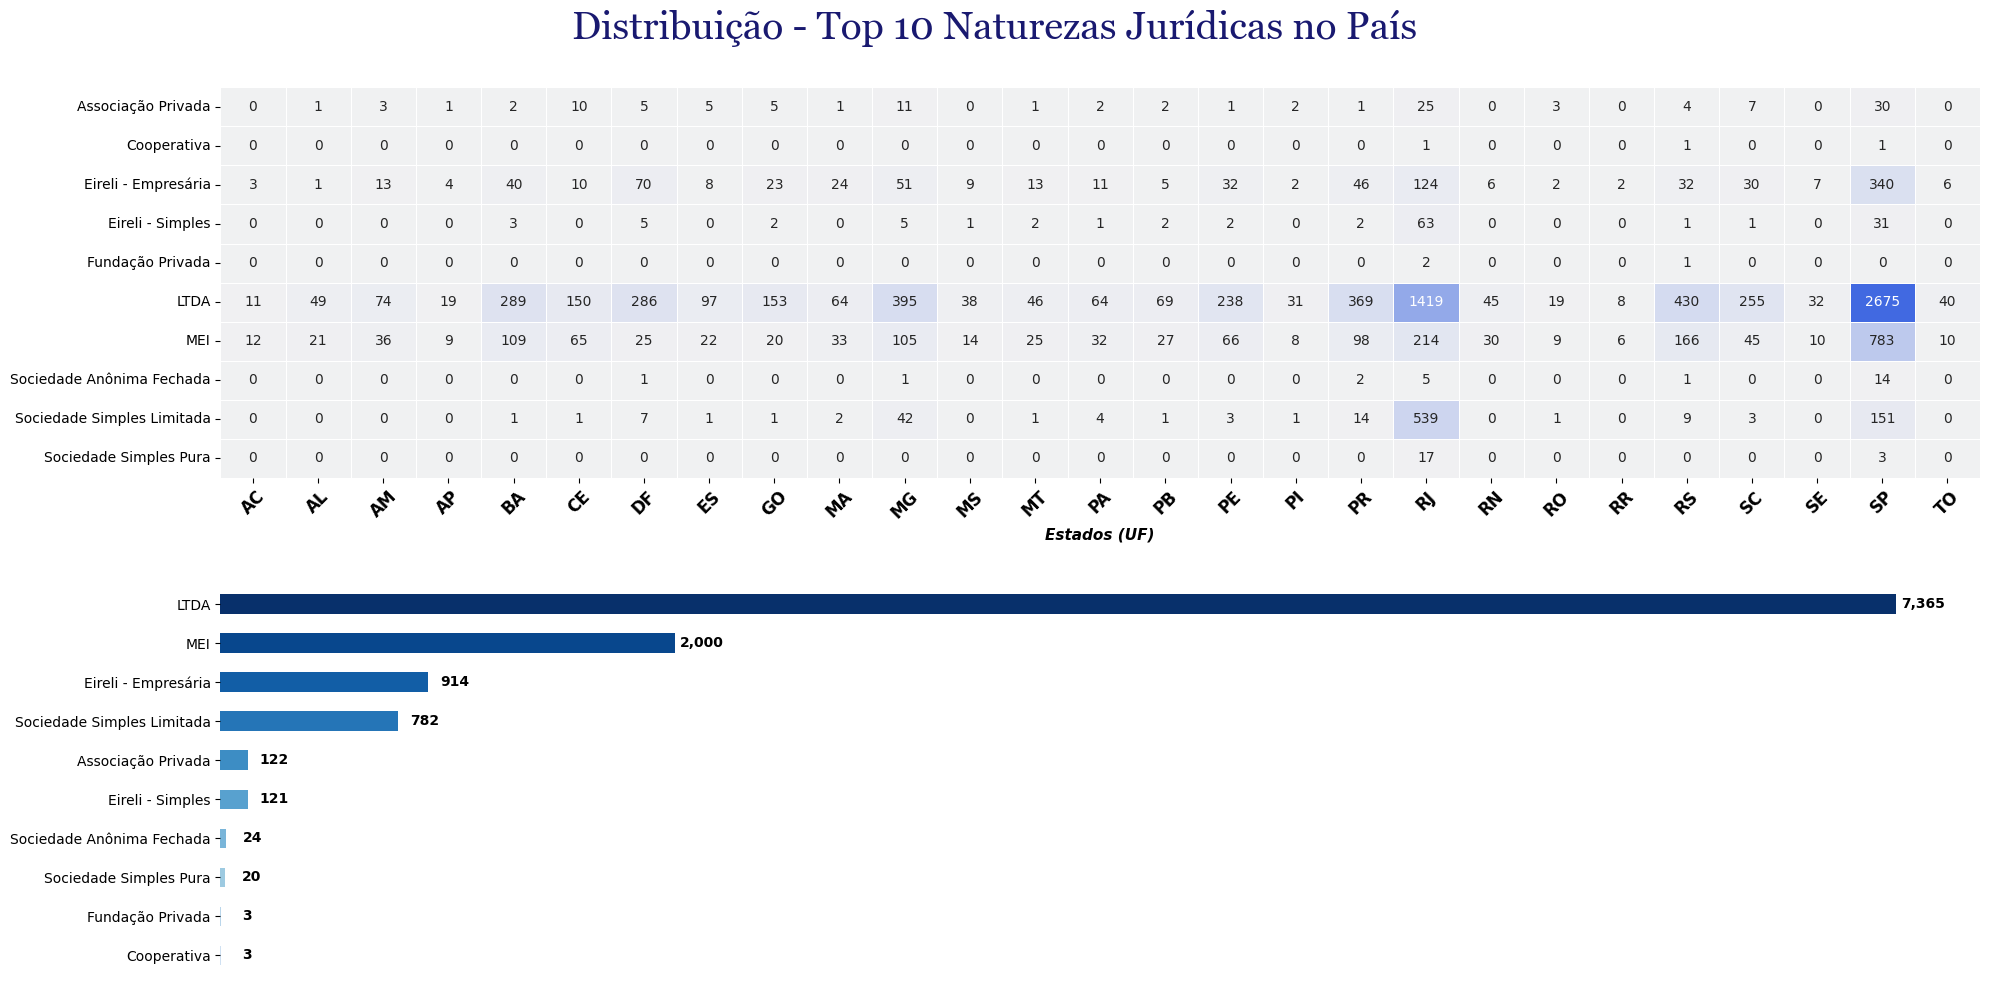

In [ ]:
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]


natureza_juridica = pd.DataFrame(agnts_tabela_unificada)
natureza_juridica['NATUREZA_JURIDICA'] = natureza_juridica['NATUREZA_JURIDICA'].replace({
    'Sociedade Empresária Limitada': 'LTDA',
    'Empresário (Individual)': 'MEI',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)': 'Eireli - Empresária',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)': 'Eireli - Simples'
})
ranking_natureza_juridica_top_10 = natureza_juridica['NATUREZA_JURIDICA'].value_counts().head(10)

cores = plt.cm.Blues(np.linspace(0.2, 1, len(ranking_natureza_juridica_top_10)))
ranking_natureza_juridica_top_10.sort_values(ascending=True).plot(kind='barh', color=cores, ax=axs[1])

for n in axs[1].patches:
    axs[1].annotate(format(n.get_width(), ',.0f'),
                    (n.get_width(), n.get_y() + n.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(19, 0),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

axs[1].set_title('   ', fontsize=17, fontweight='medium')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontweight='medium')
axs[1].set_xticks([])
# axs[0].box(False)
# axs[0].set_yticks(fontweight='bold')
# axs[0].tight_layout()


pivot_table = pd.crosstab(natureza_juridica['NATUREZA_JURIDICA'], natureza_juridica['UF'])
cor = sns.color_palette("light:royalblue", as_cmap=True)
axs[0] = sns.heatmap(pivot_table, annot=True, fmt='d', linewidths=0.5, cmap=cor, ax=axs[0], cbar=False)
axs[0].set_xlabel('Estados (UF)', fontweight='bold', fontsize=11, fontstyle='oblique')
axs[0].set_ylabel(None)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontweight='medium', rotation=0)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontweight='bold', fontsize=12, rotation=45)
axs[0].set_title("   ", fontsize=20)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Distribuição - Top 10 Naturezas Jurídicas no País', fontdict=fontprops, fontsize=28)
plt.subplots_adjust(top=1.87)
plt.subplots_adjust(hspace=1.5)
# plt.suptitle('Quantidade de Agentes por natureza jurídica', fontsize=14)
plt.box([])
plt.tight_layout()
plt.show()


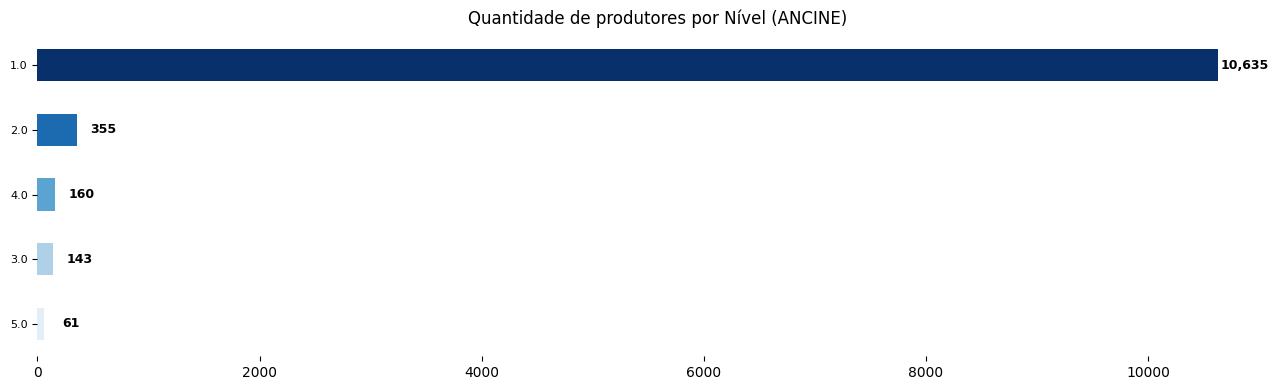

In [ ]:
nivel_produtora_5 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 5.0]
nivel_produtora_4 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 4.0]
nivel_produtora_3 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 3.0]

nivel_produtora = agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].value_counts()
plt.figure(figsize=(13,4))
cores = plt.cm.Blues(np.linspace(0.1, 1, len(nivel_produtora)))
ax = nivel_produtora.sort_values(ascending=True).plot(kind='barh', color=cores)

for n in ax.patches:
        ax.annotate(format(n.get_width(), ',.0f'),
                (n.get_width(), n.get_y() + n.get_height() / 2.),
                ha='center', va='center',
                xytext=(19, 0),
                textcoords='offset points',
                fontsize=9, fontweight='bold')
        
plt.ylabel(None)
plt.title('Quantidade de produtores por Nível (ANCINE)')
plt.yticks(fontsize=8)
plt.box(False)
plt.tight_layout()
plt.show()

---

## Séries Temporais

### Projetos de Renúncia Fiscal

Os dados dos projetos de renúncia fiscal apresenta uma série temporal irregular, as colunas de datas de aprovação e liberação não apresentam intervalos regulares.

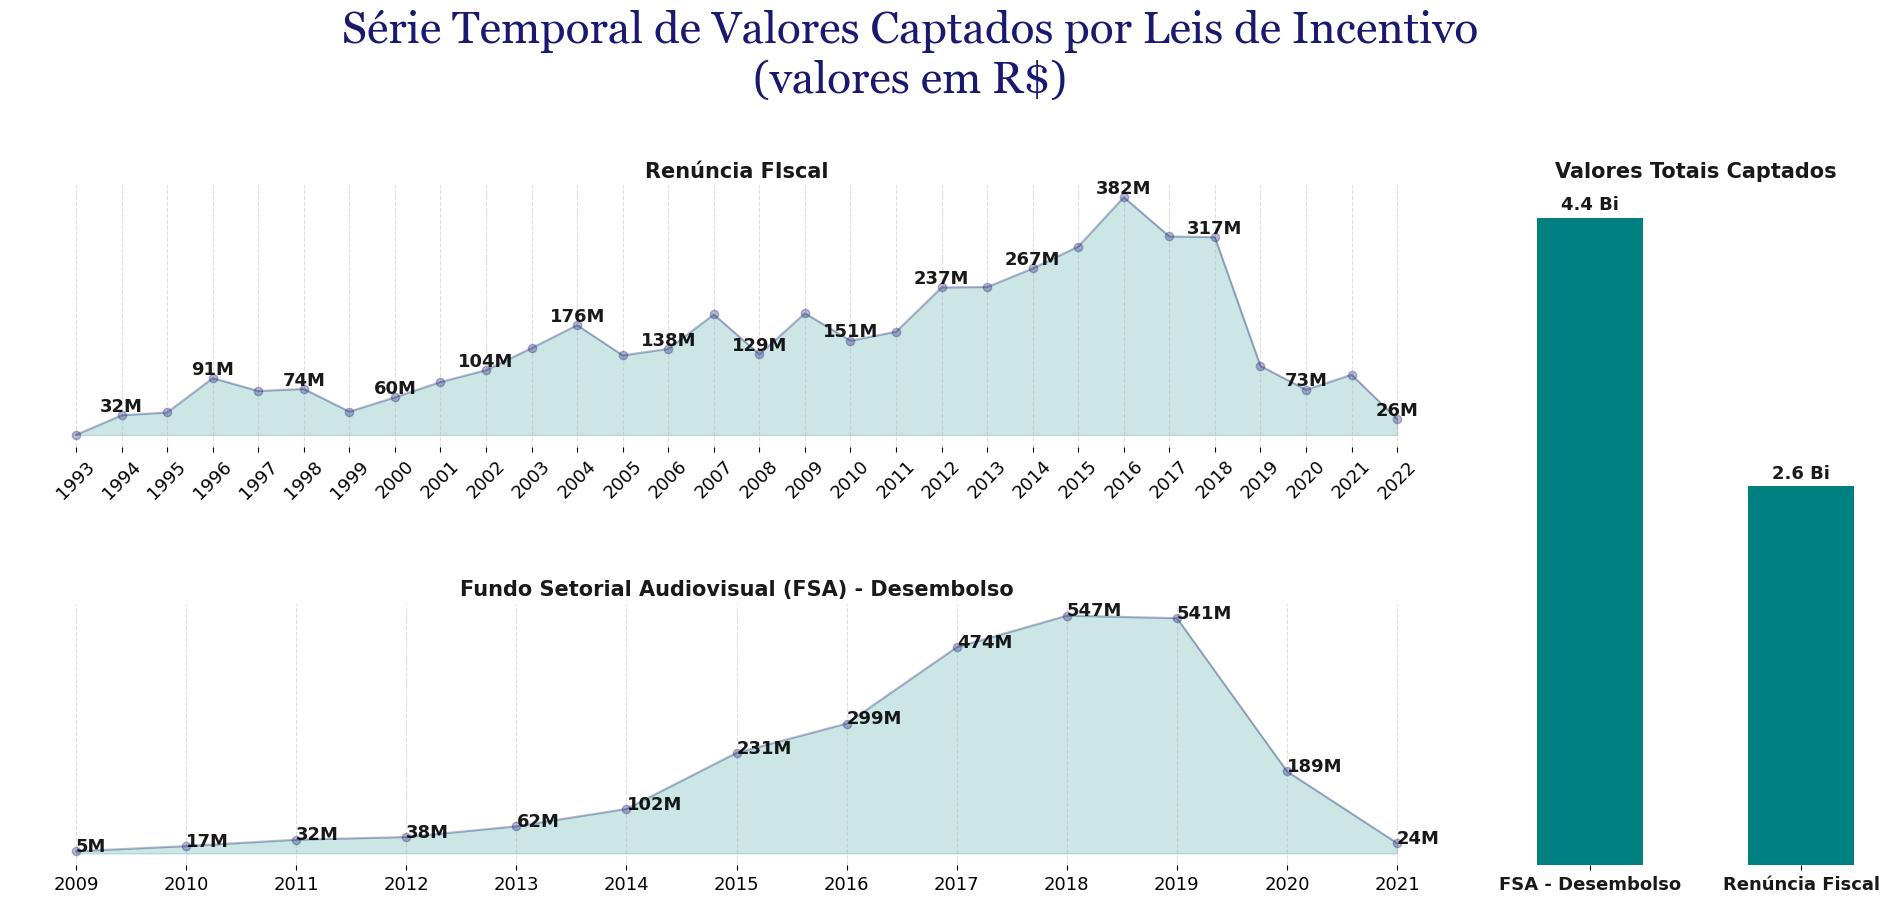

In [ ]:
def grafico_fsa_renuncia_fiscal():

    df_serie_temp_renun_fiscal = proj_renuncia_fiscal[['DT_APROVACAO_CAPTACAO', 'TOTAL_CAPTADO']]
    df_serie_temp_renun_fiscal['TOTAL_CAPTADO'] = df_serie_temp_renun_fiscal['TOTAL_CAPTADO'].str.replace(',', '.').astype(float)
    df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'] = df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'].dt.year
    df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']
    df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.groupby(df_serie_temp_renun_fiscal.index).sum().reset_index()
    df_serie_temp_renun_fiscal_ano = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']

    df_serie_temp_fsa_desembolso = proj_fsa_desembolso[['DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]
    df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'] = df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
    df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'], errors='coerce')
    df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.dropna(subset=['DT_PRIMEIRO_DESEMBOLSO'])
    df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].dt.year.astype(int)
    df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']
    df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.groupby(df_serie_temp_fsa_desembolso.index).sum().reset_index()
    df_serie_temp_fsa_desembolso_ano = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']

    total_fsa_desembolso = df_serie_temp_fsa_desembolso_ano.sum()
    total_renun_fiscal = df_serie_temp_renun_fiscal_ano.sum()


    #
    fig = plt.figure(figsize=(24,8))
    axs = [None for _ in range(3)]
    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1])
    axs[0] = fig.add_subplot(gs[0, :-1])
    axs[1] = fig.add_subplot(gs[1, :-1])
    axs[2] = fig.add_subplot(gs[0:, -1])



    def valor_index(df, numero):
        count = 0
        for index, valor in df.items():
            milhoes = valor / 1e6
            
            if numero == 0:
                count += 1 
                if count % 2 == 0:
                    axs[0].text(index, valor, f"{milhoes:.0f}M", ha='center', va='bottom', fontweight='bold', fontsize=13, color='k', alpha=0.9)
                else:
                    continue
            else:
                axs[1].text(index, valor, f"{milhoes:.0f}M", fontweight='bold', fontsize=13, color='k', alpha=0.9)

    valor_index(df_serie_temp_fsa_desembolso_ano, 1)
    valor_index(df_serie_temp_renun_fiscal_ano, 0)

    axs[0].plot(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Renun Fiscal Ano')
    axs[0].set_xticks(df_serie_temp_renun_fiscal_ano.index)
    axs[0].set_xticklabels(df_serie_temp_renun_fiscal_ano.index, rotation=45, fontweight='light', alpha=1)
    axs[0].fill_between(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color="teal", alpha=0.2)
    axs[0].tick_params(axis='x', which='minor', width=5)
    axs[0].set_yticks([])
    axs[0].grid(linestyle='dashed', alpha=0.4)
    axs[0].set_title('Renúncia FIscal', fontsize=15, fontweight='bold', alpha=0.9 )

    axs[1].plot(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Fsa Desembolso Ano')      
    axs[1].set_xticks(df_serie_temp_fsa_desembolso_ano.index)
    axs[1].set_xticklabels(df_serie_temp_fsa_desembolso_ano.index, rotation=0, fontweight='light', alpha=1)
    axs[1].fill_between(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color="teal", alpha=0.2)
    axs[1].tick_params(axis='x', which='minor', width=5)
    axs[1].set_yticks([])
    axs[1].grid(linestyle='dashed', alpha=0.4)
    axs[1].set_title('Fundo Setorial Audiovisual (FSA) - Desembolso', fontsize=15, fontweight='bold', alpha=0.9 )


    # Plotting for axs[2]

    axs[2].bar(['FSA - Desembolso', 'Renúncia Fiscal'], [total_renun_fiscal, total_fsa_desembolso], width=0.5, color='teal')
    for rect in axs[2].patches:
        height = rect.get_height()
        value_in_billions = height / 1e9  # Convert value to billions
        rounded_value = round(value_in_billions, 1)  # Round to one decimal place
        annot_text = f'{rounded_value:,.1f} Bi'
        axs[2].annotate(annot_text, xy=(rect.get_x() + rect.get_width() / 2  , height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold', fontsize=13, alpha=0.9)
    axs[2].set_xticklabels(['FSA - Desembolso', 'Renúncia Fiscal'], rotation=0, fontweight='bold', alpha=0.9)
    axs[2].set_title('Valores Totais Captados', fontsize=15, fontweight='bold', alpha=0.9)
    # Set tick parameters and labels
    for ax_single in axs:
        ax_single.tick_params(axis='both', which='major', labelsize=13) 
        ax_single.set_ylabel(None)  
        ax_single.set_yticks([])

    # Remove spines
    for ax_single in axs:
        ax_single.spines['top'].set_visible(False)
        ax_single.spines['right'].set_visible(False)
        ax_single.spines['bottom'].set_visible(False)
        ax_single.spines['left'].set_visible(False)

    # Adjust the spacing around subplots
    plt.subplots_adjust(top=0.95, bottom=0.1, wspace=0.1, hspace=0.6)

    # Add title
    fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
    plt.suptitle('Série Temporal de Valores Captados por Leis de Incentivo\n(valores em R$)', fontdict=fontprops, fontsize=32, y=1.17)
    # Show the plot
    plt.show()

grafico_fsa_renuncia_fiscal()

---

## Estatística Descritiva

#### Adequando dataframes

### Análise Estatística

In [ ]:
def stats_df(df):

    numerical = df.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))

    media = pd.DataFrame(numerical.mean()).T
    mediana = pd.DataFrame(numerical.median()).T

    desvio_padrao = pd.DataFrame(numerical.apply(np.std)).T
    minimo = pd.DataFrame(numerical.min()).T
    maximo = pd.DataFrame(numerical.max()).T
    range = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(numerical.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T

    nome_stats_df = 'stats_' + str(df)
    nome_stats_df = pd.concat([media, mediana, desvio_padrao, minimo, maximo, range, skew, kurtosis]).T.reset_index()

    if df is fsa_desembolso:
        nome_df = 'FSA - Desembolso'
    else:
        nome_df = 'Renúncia Fiscal'
    nome_stats_df.columns = [nome_df, 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo', 'Range', 'Skew', 'Kurtosis']
    return nome_stats_df


In [ ]:
stats_df(renuncia_fiscal)

,Renúncia Fiscal,Média,Mediana,Desvio Padrão,Mínimo,Máximo,Range,Skew,Kurtosis
0,REGISTRO_ANCINE,6.732374e+03,1288.0,9.352180e+03,1.0,4.919500e+04,4.919400e+04,1.551831,1.760444
1,CLASSIFICACAO_NIVEL_PRODUTORA,3.548103e+00,4.0,1.443481e+00,1.0,5.000000e+00,4.000000e+00,-0.572314,-1.085240
2,LEI_8313,7.759371e+04,0.0,2.706875e+05,0.0,3.313201e+06,3.313201e+06,5.191387,34.062702
3,ART1,2.517539e+05,0.0,5.737106e+05,0.0,4.000000e+06,4.000000e+06,3.010705,9.599093
4,ART1A,2.865164e+05,0.0,5.680820e+05,0.0,4.000000e+06,4.000000e+06,2.946871,10.592457
5,ART3,2.369118e+05,0.0,6.743896e+05,0.0,4.320000e+06,4.320000e+06,3.142201,9.061842
6,ART3A,3.895909e+05,0.0,8.392261e+05,0.0,3.000000e+06,3.000000e+06,2.242597,3.692846
7,ART39,2.496303e+05,0.0,1.033442e+06,0.0,1.463493e+07,1.463493e+07,7.056844,64.568354
8,FUNCINES,2.447739e+04,0.0,2.166931e+05,0.0,6.000000e+06,6.000000e+06,15.377741,319.888224
9,TOTAL_CAPTADO,1.516474e+06,812000.0,1.670596e+06,0.0,1.463493e+07,1.463493e+07,2.050779,6.684717


In [ ]:
stats_df(fsa_desembolso)

,FSA - Desembolso,Média,Mediana,Desvio Padrão,Mínimo,Máximo,Range,Skew,Kurtosis
0,REGISTRO_ANCINE,12405.355204,13029.00,10858.425570,3.00,46335.0,46332.00,0.472236,-0.930614
1,CLASSIFICACAO_NIVEL_PRODUTORA,2.733970,3.00,1.536581,1.00,5.0,4.00,0.182527,-1.503488
2,ANO_CHAMADA_PUBLICA,2014.917984,2015.00,2.234697,2008.00,2020.0,12.00,-0.105695,0.166489
3,VL_CONTRATO_DOU,673425.733278,434109.65,718085.274060,5853.11,6107400.0,6101546.89,2.213104,6.634189
4,VL_TOTAL_LIBERADO,640483.844837,400000.00,713290.155240,0.00,6107400.0,6107400.00,2.249797,6.901420


In [ ]:
fsa_desembolso_numerical = fsa_desembolso.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))
renuncia_fiscal_numerical = renuncia_fiscal.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))


def plot_hist_renuncia_fiscal():

    fig = plt.figure(figsize=(18,10))
    axs = [None] * 4
    gs = gridspec.GridSpec(2, 2)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])

    n_bins = 40

    labels = {
        'CLASSIFICACAO_NIVEL_PRODUTORA' : 'Nível de Classificação',
        'ANO_CHAMADA_PUBLICA' : 'Ano da Chamada Pública',
        'VL_CONTRATO_DOU' : 'Valor do Contrato',
        'VL_TOTAL_LIBERADO' : 'Valor Liberado',
    }

    #Plot Hist - Renúncia Fiscal
    for i, column in enumerate(['CLASSIFICACAO_NIVEL_PRODUTORA', 'ANO_CHAMADA_PUBLICA', 'VL_CONTRATO_DOU', 'VL_TOTAL_LIBERADO']):
        sns.histplot(fsa_desembolso_numerical[column], bins=n_bins, kde=True, ax=axs[i], 
                     stat='percent', line_kws={'color': 'red'})
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)


    plt.tight_layout()
    plt.show()

def plot_hist_fsa_desembolso():
    
    fig = plt.figure(figsize=(16,12))
    axs = [None] * 8
    gs = gridspec.GridSpec(4, 3)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])
    axs[4] = fig.add_subplot(gs[2,0])
    axs[5] = fig.add_subplot(gs[2,1])
    axs[6] = fig.add_subplot(gs[3,0])
    axs[7] = fig.add_subplot(gs[3,1])

    n_bins = 40

    labels = {
        'LEI_8313' : 'Lei 8313 (Lei Rouanet)',
        'ART1' : 'Artigo 1°',
        'ART1A' : 'Artigo 1°.A',
        'ART3' : 'Artigo 3°',
        'ART3A' : 'Artigo 3°.A',
        'ART39' : 'Artigo 39°',
        'FUNCINES' : 'FUNCINES - Fundo Municipal de Cinema',
        'TOTAL_CAPTADO' : 'Total Captado',
    }
    #Plot Hist - FSA - Desembolso
    for i, column in enumerate(['LEI_8313', 'ART1',
        'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO']):
        sns.histplot(renuncia_fiscal_numerical[column], bins=n_bins, kde=True, ax=axs[i], stat='percent')
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)
    # plt.box([])
    plt.tight_layout()
    plt.show()

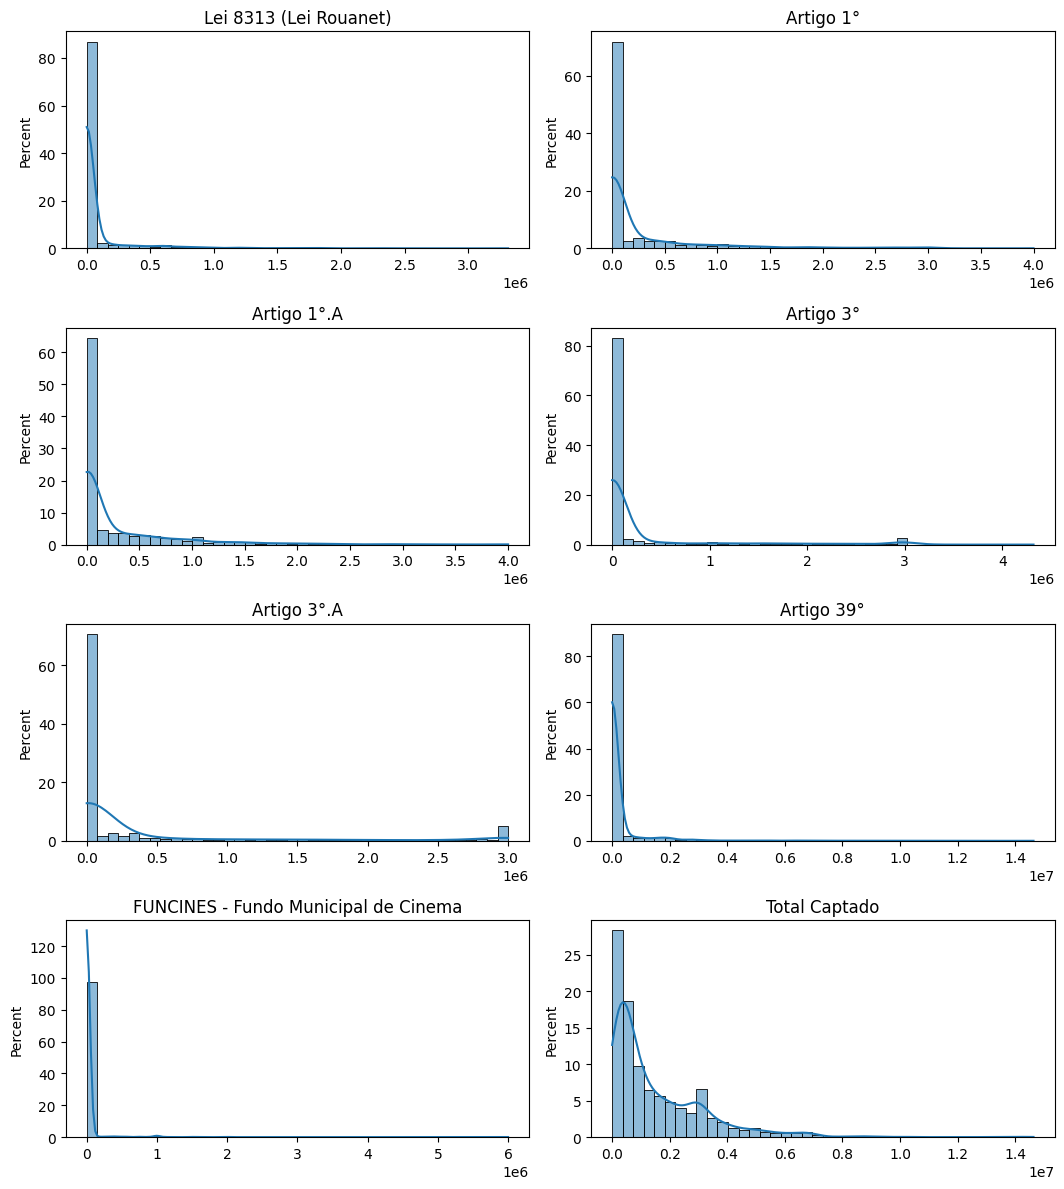

In [ ]:
plot_hist_fsa_desembolso()

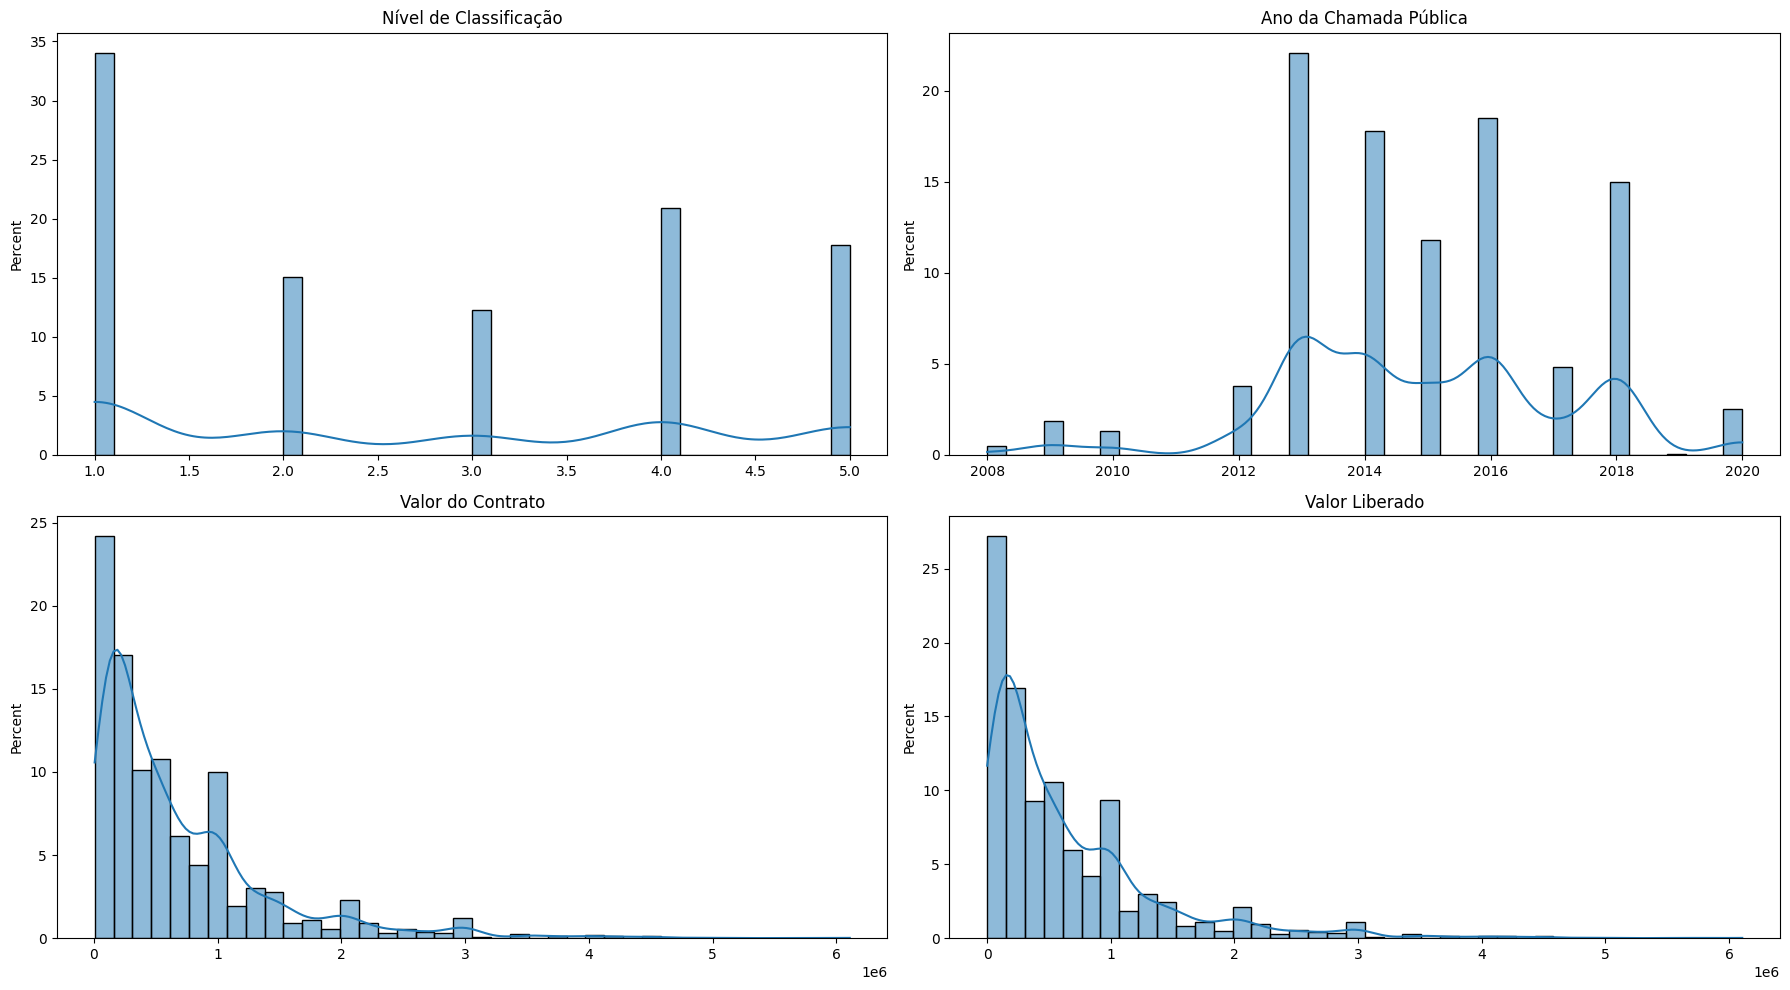

In [ ]:
plot_hist_renuncia_fiscal()

---

## Feature Engineering

### Criação de Hipóteses

### FSA - Desembolso

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 
* O número de projetos aprovados em um estado é diretamente proporcional a quantidade de projetos inscritos, independentemente de localização

### Renúncia Fiscal

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 


---


**Qual é a distribuição geográfica das produções cinematográficas no Brasil? Há concentração em determinadas regiões?**  

**Qual é o perfil dos investidores na indústria cinematográfica brasileira? Há diferenças significativas entre investidores de produções de grande escala e produções independentes?**  

In [ ]:
def perfil_df(df):
    pd.options.display.max_columns = None
    print(df.info())
    return df.sample(5)
    

# perfil_df(fsa_desembolso)
perfil_df(renuncia_fiscal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                2609 non-null   int64         
 1   DATA_REGISTRO                  2609 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   2609 non-null   object        
 3   CNPJ                           2609 non-null   object        
 4   DATA_CONSTITUICAO              2609 non-null   datetime64[ns]
 5   UF                             2609 non-null   object        
 6   MUNICIPIO                      2609 non-null   object        
 7   NATUREZA_JURIDICA              2609 non-null   object        
 8   ATIVIDADE_ECONOMICA            2609 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  2609 non-null   int32         
 10  TITULO_PROJETO                 2609 non-null   object        
 11  LEI_8313         

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,TITULO_PROJETO,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO,DT_APROVACAO_CAPTACAO,DT_1_LIBERACAO
771,713,2002-11-04,CARIRI PRODUÇÕES ARTÍSTICAS LTDA.,10.505.568/0001-18,1986-05-05,CE,FORTALEZA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,CORISCO E DADA,0.0,244772.0,0.0,0.0,0.0,0.0,0.0,244772.0,1994-09-12,1997-02-04
1083,975,2004-03-03,CARIBE PRODUÇÕES LTDA,32.267.676/0001-32,1989-01-24,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",3,"Duas Pátrias, Dois Amores (Ex - Albino, O Port...",0.0,0.0,500000.0,0.0,0.0,0.0,0.0,500000.0,2011-06-21,2013-03-28
825,786,2004-03-08,RACCORD PRODUÇÕES ARTÍSTICAS E CINEMATOGRÁFICA...,72.062.029/0001-09,1993-03-23,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,VOVÓ TATÁ - ANIMAÇÃO,0.0,0.0,0.0,0.0,3000000.0,0.0,0.0,3000000.0,2022-06-15,2022-12-20
2324,21011,2012-03-02,FR TARGET FILMES LTDA,05.379.977/0001-85,2002-10-31,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",2,O Caricaturista,0.0,0.0,0.0,0.0,150000.0,0.0,0.0,150000.0,2016-08-10,2022-01-25
398,292,2004-03-29,TRUQUE PRODUTORA DE CINEMA TV E VÍDEO LTDA,16.487.027/0001-90,1988-07-27,BA,SALVADOR,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,Pau Brasil,0.0,200000.0,0.0,0.0,0.0,0.0,0.0,200000.0,2007-12-06,2009-01-22
